In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [2]:
SEED = 21
def seed_everythings(seed,tensorflow_init=True,pytorch_init=True):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    if tensorflow_init is True:
        tf.random.set_seed(seed)
    if pytorch_init is True:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    

# 1) EDA

## 1.1) Missing values inspection and diff between train/test

In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')
train_label = train['failure']

train.drop(['failure','id','product_code','attribute_0',
           'attribute_1'],inplace = True,axis = 1)
train.drop_duplicates(inplace = True)
test.drop(['id','product_code','attribute_0',
           'attribute_1'],inplace = True,axis = 1)
test.drop_duplicates(inplace = True)

print(f'train data shape: {train.shape}')
print(f'test data shape: {test.shape}')

def check_missing(df):
    missing_sum = df.isna().sum()
    missing_freq = missing_sum/len(df)
    missing_df = pd.concat([missing_sum,missing_freq],axis = 1)
    missing_df = missing_df.rename(columns = {0:'total missing',1:'% missing'})
    tmp = missing_df[missing_df.iloc[:,0]!=0].sort_values('% missing',ascending=False).round(2)
    
    print(f'out of {df.shape[1]} features, there are {tmp.shape[0]} features have missing values')
    return tmp

check_missing(train)
#check_missing(test).head()
    

train data shape: (26570, 21)
test data shape: (20775, 21)
out of 21 features, there are 16 features have missing values


,total missing,% missing
measurement_17,2284,0.09
measurement_16,2110,0.08
measurement_15,2009,0.08
measurement_14,1874,0.07
measurement_13,1774,0.07
measurement_12,1601,0.06
measurement_11,1468,0.06
measurement_10,1300,0.05
measurement_9,1227,0.05
measurement_8,1048,0.04


In [4]:
!pip install missingno 

<AxesSubplot:>

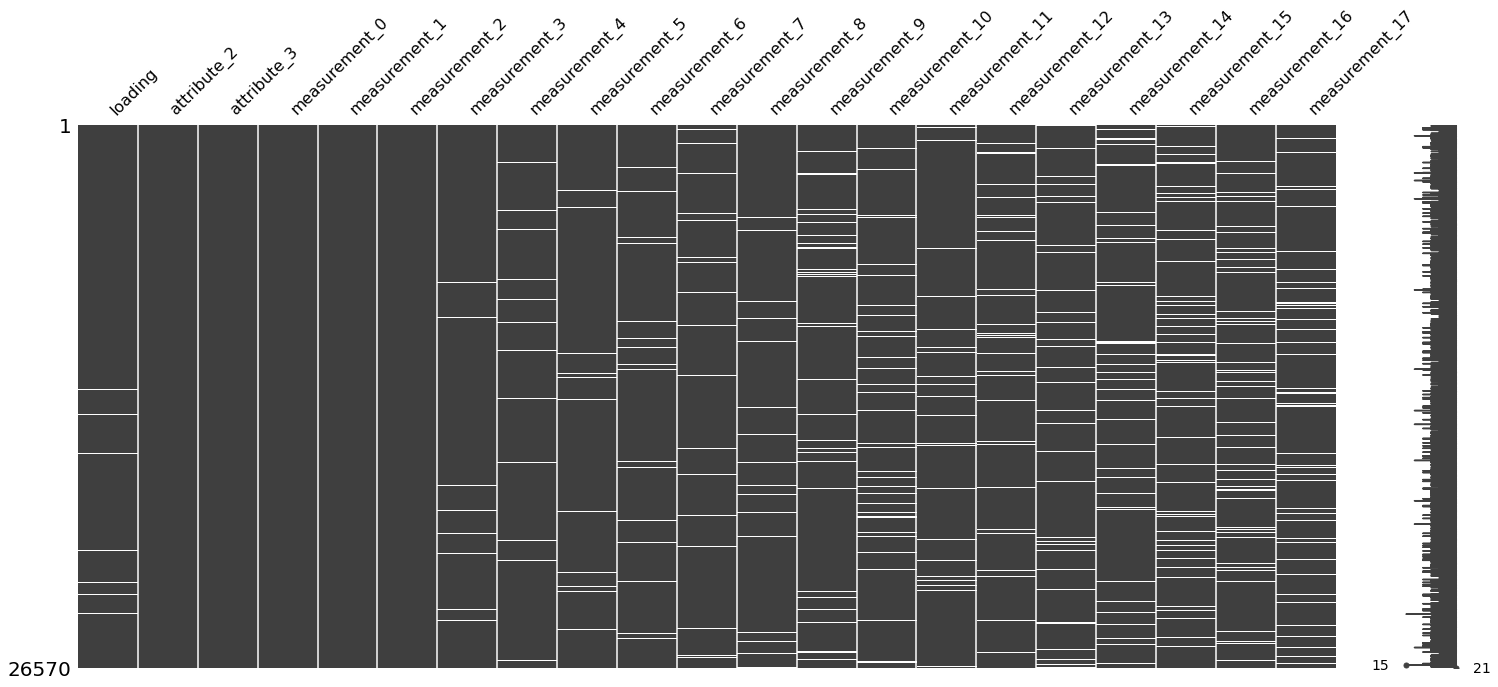

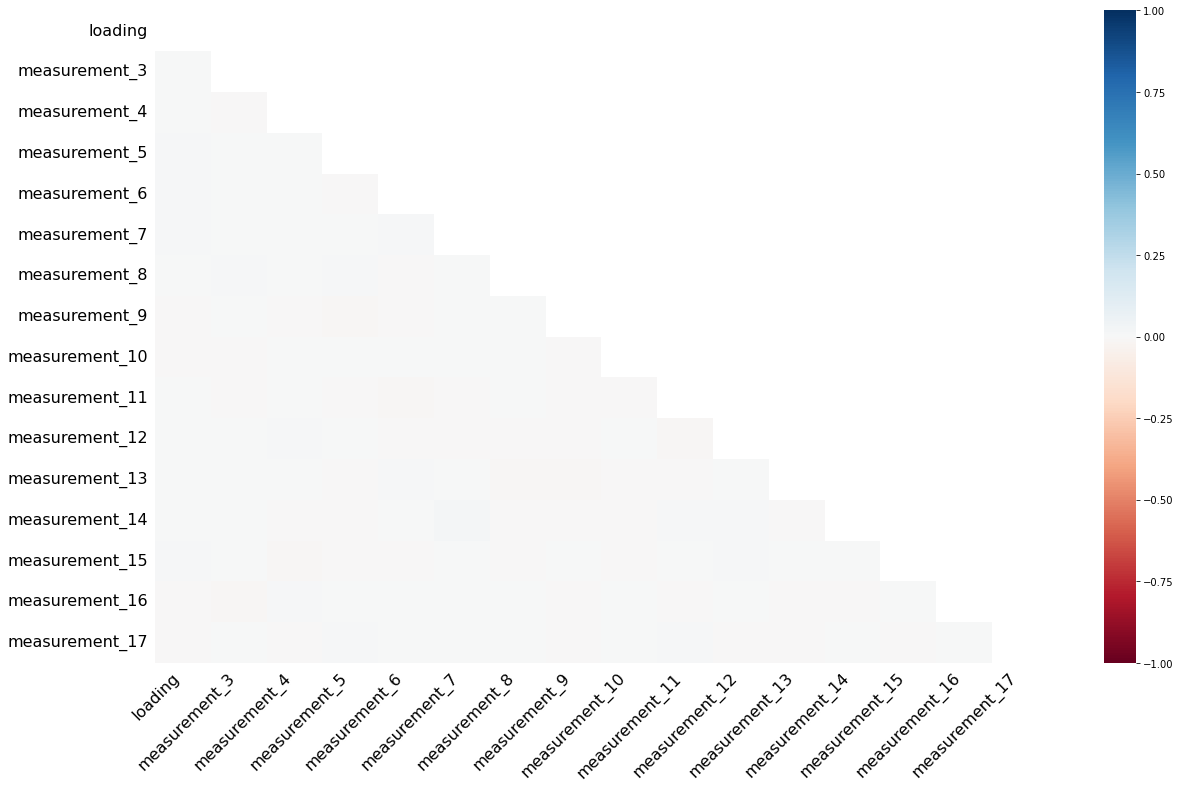

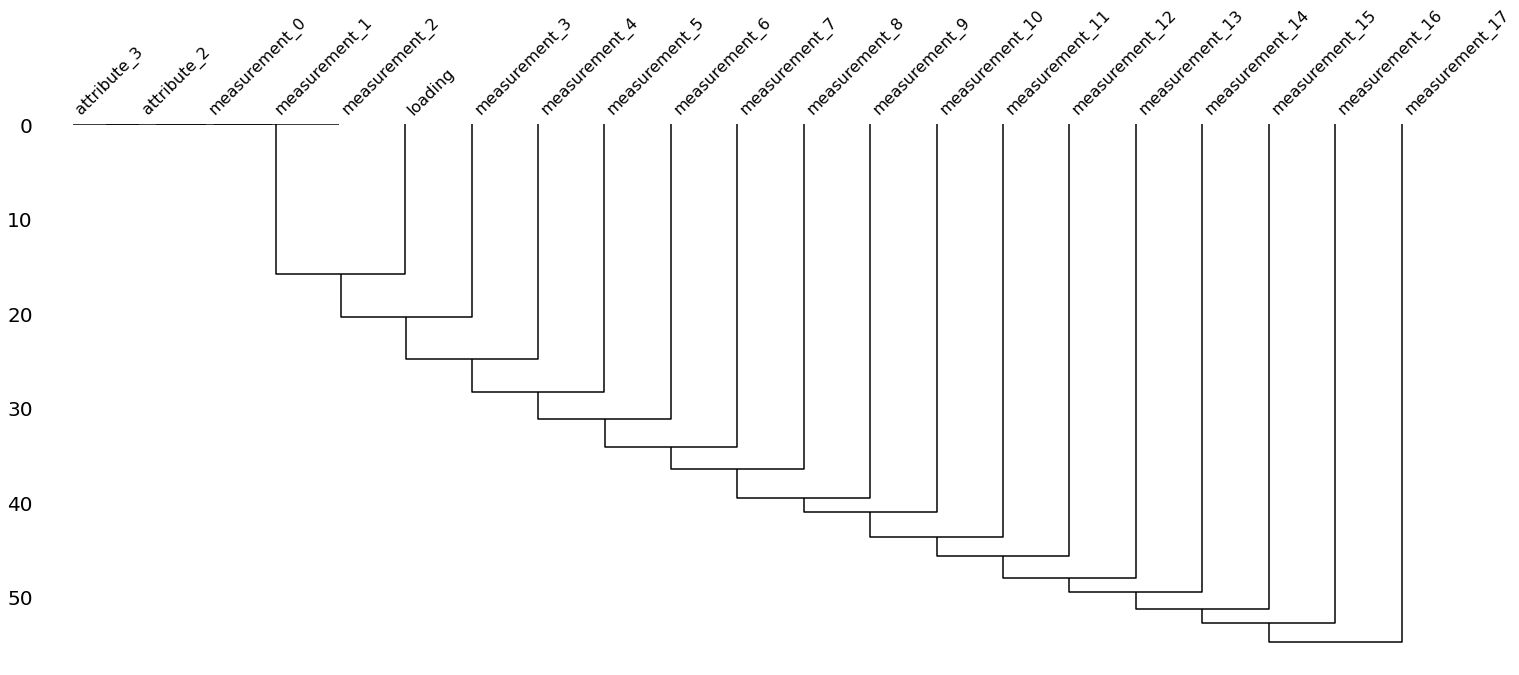

In [5]:
import missingno as msno
msno.matrix(train)
msno.heatmap(train)
msno.dendrogram(train)

In [6]:
cate_cols = train.select_dtypes(['object'])
def diff_between_train_test(train,test,cate_cols):
    ans = {}
    for col in cate_cols:
        train_val = np.unique(train[col].values)
        test_val = np.unique(test[col].values)
        mismatched_codes = len(np.setdiff1d(train_val, test_val))
        if mismatched_codes:
            ans[col]=mismatched_codes
    return pd.Series(ans)

diff_between_train_test(train,test,cate_cols)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


Series([], dtype: float64)

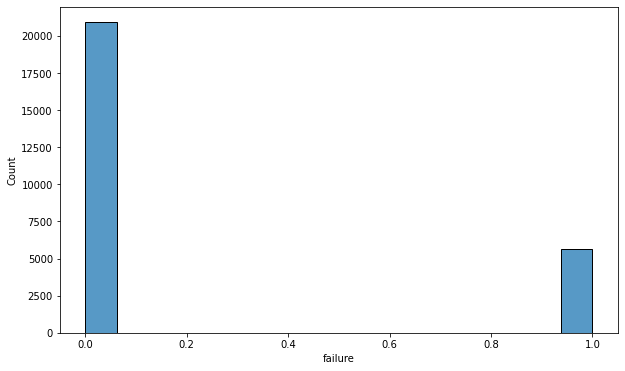

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(train_label, ax=ax)
plt.show()

array([[<AxesSubplot:title={'center':'loading'}>,
        <AxesSubplot:title={'center':'attribute_2'}>,
        <AxesSubplot:title={'center':'attribute_3'}>,
        <AxesSubplot:title={'center':'measurement_0'}>,
        <AxesSubplot:title={'center':'measurement_1'}>],
       [<AxesSubplot:title={'center':'measurement_2'}>,
        <AxesSubplot:title={'center':'measurement_3'}>,
        <AxesSubplot:title={'center':'measurement_4'}>,
        <AxesSubplot:title={'center':'measurement_5'}>,
        <AxesSubplot:title={'center':'measurement_6'}>],
       [<AxesSubplot:title={'center':'measurement_7'}>,
        <AxesSubplot:title={'center':'measurement_8'}>,
        <AxesSubplot:title={'center':'measurement_9'}>,
        <AxesSubplot:title={'center':'measurement_10'}>,
        <AxesSubplot:title={'center':'measurement_11'}>],
       [<AxesSubplot:title={'center':'measurement_12'}>,
        <AxesSubplot:title={'center':'measurement_13'}>,
        <AxesSubplot:title={'center':'measurement_1

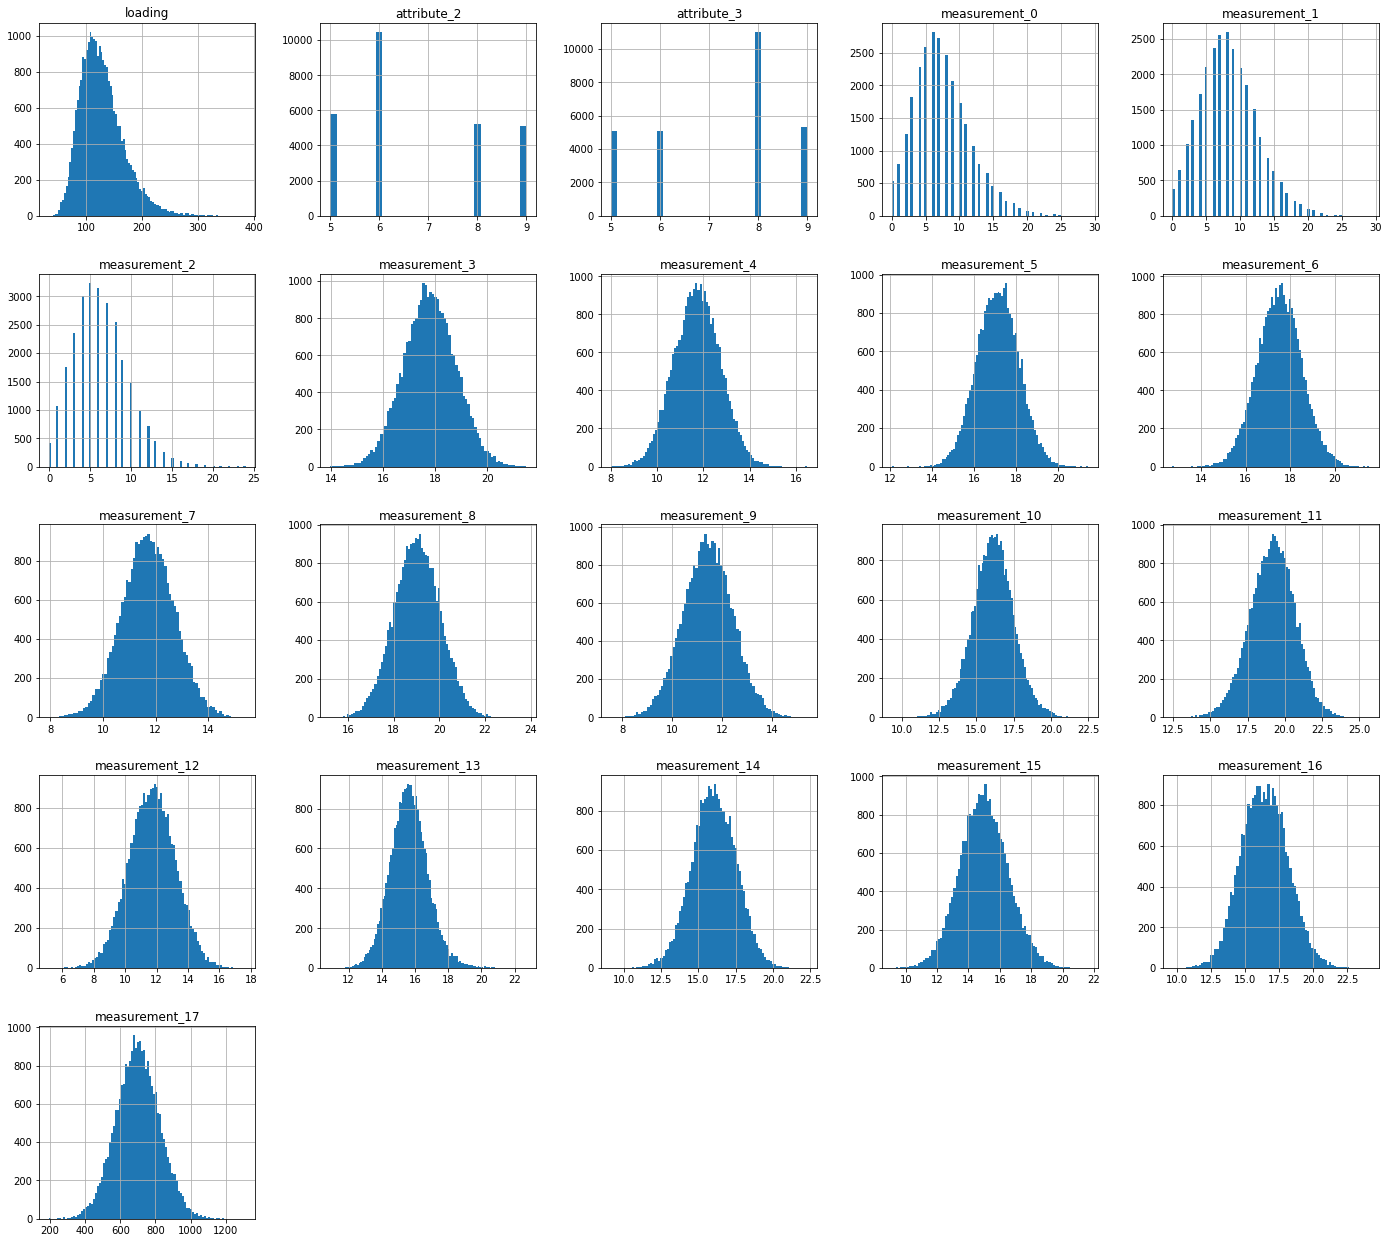

In [8]:
train.hist(bins='auto',figsize=(24, 22))

array([[<AxesSubplot:title={'center':'loading'}>,
        <AxesSubplot:title={'center':'attribute_2'}>,
        <AxesSubplot:title={'center':'attribute_3'}>,
        <AxesSubplot:title={'center':'measurement_0'}>,
        <AxesSubplot:title={'center':'measurement_1'}>],
       [<AxesSubplot:title={'center':'measurement_2'}>,
        <AxesSubplot:title={'center':'measurement_3'}>,
        <AxesSubplot:title={'center':'measurement_4'}>,
        <AxesSubplot:title={'center':'measurement_5'}>,
        <AxesSubplot:title={'center':'measurement_6'}>],
       [<AxesSubplot:title={'center':'measurement_7'}>,
        <AxesSubplot:title={'center':'measurement_8'}>,
        <AxesSubplot:title={'center':'measurement_9'}>,
        <AxesSubplot:title={'center':'measurement_10'}>,
        <AxesSubplot:title={'center':'measurement_11'}>],
       [<AxesSubplot:title={'center':'measurement_12'}>,
        <AxesSubplot:title={'center':'measurement_13'}>,
        <AxesSubplot:title={'center':'measurement_1

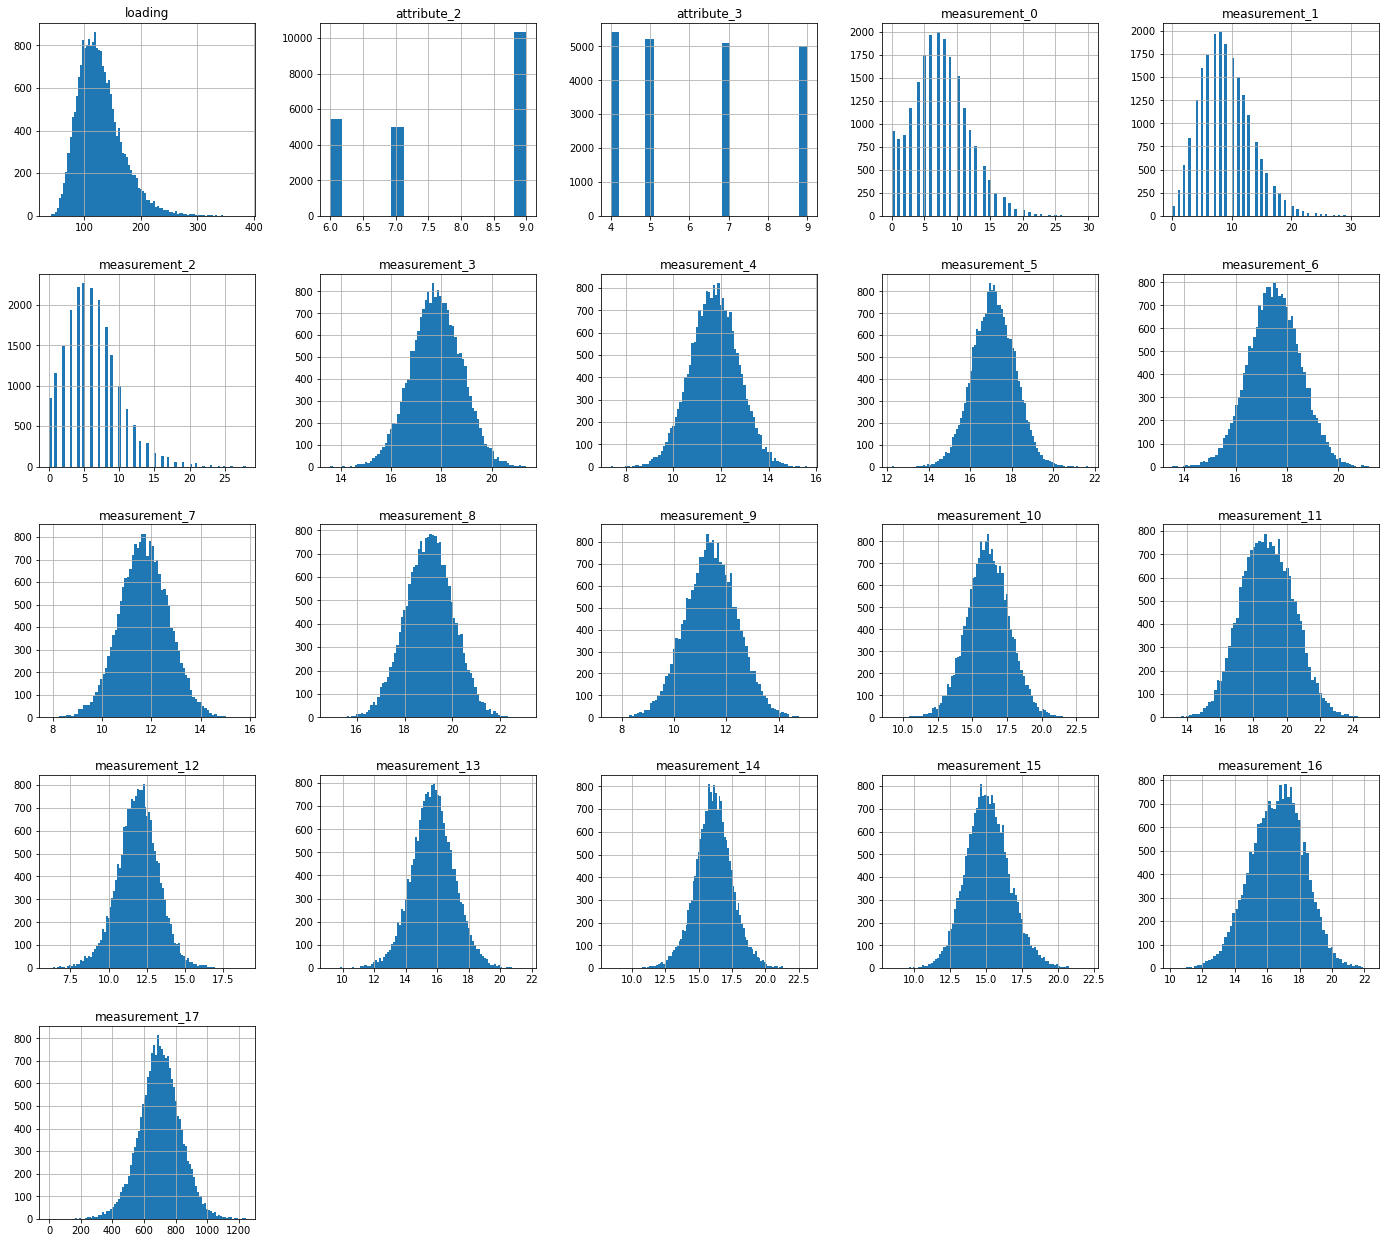

In [9]:
test.hist(bins='auto',figsize=(24, 22))

## 1.2) Data cleaning/normalizing/imputing

In [10]:
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from category_encoders.quantile_encoder import SummaryEncoder
from category_encoders.ordinal import OrdinalEncoder
te = TargetEncoder(cols = cate_cols,handle_missing = 'return_nan')
te.fit(train,train_label)



/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


TargetEncoder(cols=Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[26570 rows x 0 columns],
              handle_missing='return_nan')

In [11]:
train=te.transform(train)
test=te.transform(test)

continues_table_train = train.loc[:,~train.columns.isin(cate_cols)]
cate_table_train = train.loc[:,train.columns.isin(cate_cols)]
continues_table_test = test.loc[:,~test.columns.isin(cate_cols)]
cate_table_test = test.loc[:,test.columns.isin(cate_cols)]

In [12]:
# s_imputer = SimpleImputer(strategy = 'most_frequent')
knn_imputer = KNNImputer()

continues_table_train = knn_imputer.fit_transform(continues_table_train)
continues_table_test = knn_imputer.transform(continues_table_test)

# cate_table_train = s_imputer.fit_transform(cate_table_train)
# cate_table_test = s_imputer.transform(cate_table_test)

## 1.3) Adversarial Validation

In [13]:
train_cleaned = np.concatenate([continues_table_train,cate_table_train],axis = 1)
test_cleaned = np.concatenate([continues_table_test,cate_table_test],axis = 1)

In [14]:
import numpy as np 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
X = np.concatenate([train_cleaned,test_cleaned],axis = 0)
y = [0]*len(train_cleaned)+[1]*len(test_cleaned)

model = RandomForestClassifier(n_estimators=100)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

In [15]:
X

array([[ 80.1  ,   9.   ,   5.   , ...,  13.034,  14.684, 764.1  ],
       [ 84.89 ,   9.   ,   5.   , ...,  14.395,  15.631, 682.057],
       [ 82.43 ,   9.   ,   5.   , ...,  14.094,  17.946, 663.376],
       ...,
       [ 67.73 ,   9.   ,   5.   , ...,  14.175,  17.728, 783.349],
       [126.15 ,   9.   ,   5.   , ...,  16.437,  15.179, 745.21 ],
       [ 85.97 ,   9.   ,   5.   , ...,  16.261,  16.482, 647.98 ]])

In [16]:
print(roc_auc_score(y_true=y, y_score=cv_preds[:,1]))
cv_preds

0.7526179005392744


array([[0.  , 1.  ],
       [0.02, 0.98],
       [0.03, 0.97],
       ...,
       [0.55, 0.45],
       [0.39, 0.61],
       [0.16, 0.84]])

In [17]:
col_reorder = list(train.columns[~train.columns.isin(cate_cols)].values)+list(train.columns[train.columns.isin(cate_cols)].values)
col_reorder

['loading',
 'attribute_2',
 'attribute_3',
 'measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [18]:
model.fit(X,y)
ranks = sorted(list(zip(col_reorder, model.feature_importances_)),key=lambda x: x[1], reverse=True)
for feature, score in ranks:
    print(f"{feature:10} : {score:0.4f}")

attribute_3 : 0.3874
attribute_2 : 0.3047
measurement_1 : 0.0546
measurement_0 : 0.0320
measurement_15 : 0.0249
measurement_11 : 0.0243
measurement_13 : 0.0194
measurement_12 : 0.0185
measurement_16 : 0.0171
measurement_14 : 0.0171
measurement_2 : 0.0168
measurement_10 : 0.0151
measurement_17 : 0.0085
measurement_5 : 0.0076
measurement_4 : 0.0076
measurement_3 : 0.0075
loading    : 0.0075
measurement_9 : 0.0074
measurement_6 : 0.0074
measurement_7 : 0.0074
measurement_8 : 0.0074


## 1.4) Cluster Analaysis

### 1.4.1) Kmean

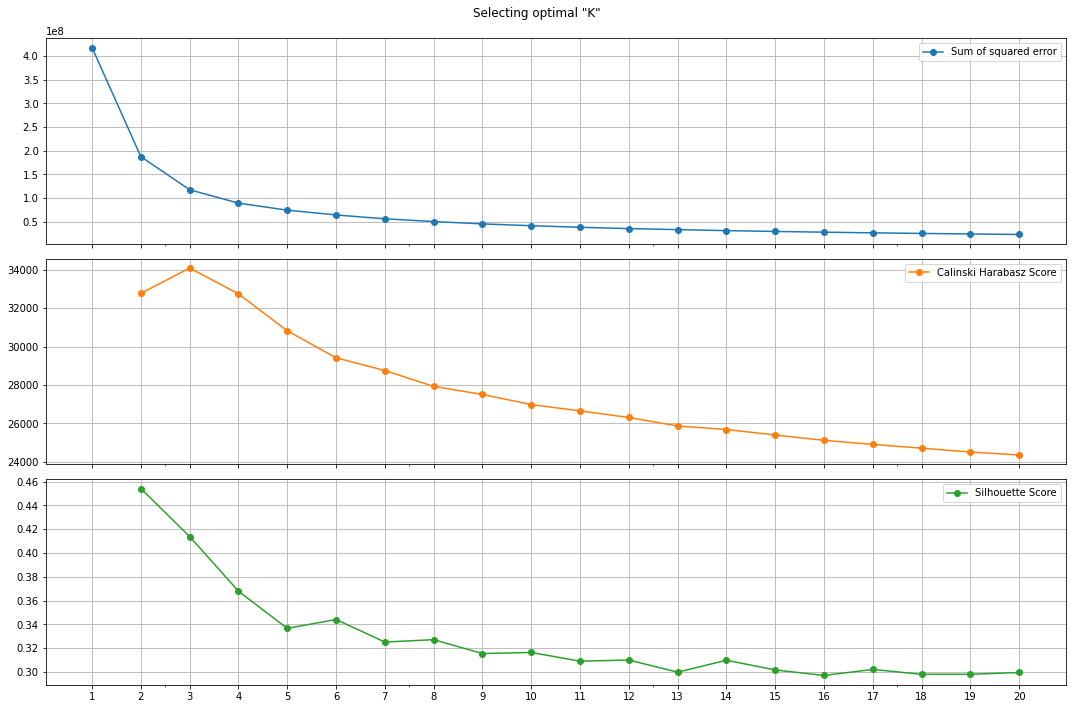

In [19]:
#source: https://towardsdatascience.com/selecting-optimal-k-for-k-means-clustering-c7579fd2e926
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
X_segmentation = train_cleaned
search_range = range(1, 21)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(X_segmentation)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(X_segmentation)
        chs = metrics.calinski_harabasz_score(X_segmentation, cluster)
        ss = metrics.silhouette_score(X_segmentation, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

### 1.4.2) T-sne

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
my_tsne = TSNE(init='pca',perplexity=50)
colors = ['blue' if i==1 else 'red' for i in train_label]
#std_scaler = StandardScaler()
#train_cleaned_scaled = std_scaler.fit_transform(train_cleaned)
embeded = my_tsne.fit_transform(train_cleaned)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


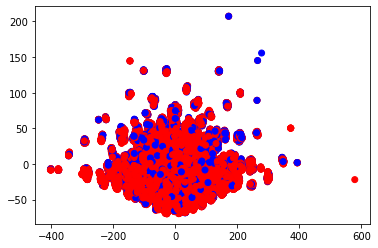

In [21]:
plt.scatter(embeded[:,0],embeded[:,1],c=colors)

## 1.5) Data Engineer

In [22]:
train_cleaned_df = pd.DataFrame(train_cleaned,columns = col_reorder)
test_cleaned_df = pd.DataFrame(test_cleaned,columns = col_reorder)

In [23]:
train_cleaned_df[['attribute_2','attribute_3','measurement_0','measurement_1','measurement_2']]=train_cleaned_df[['attribute_2','attribute_3','measurement_0','measurement_1','measurement_2']].astype('int64')
train_cleaned_df

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,80.10,9,5,7,8,4,18.040,12.5180,15.748,19.292,...,20.155,10.6720,15.859,17.5940,15.193,15.029,14.5984,13.034,14.6840,764.100
1,84.89,9,5,14,3,3,18.213,11.5400,17.717,17.893,...,17.889,12.4480,17.947,17.9150,11.755,14.732,15.4250,14.395,15.6310,682.057
2,82.43,9,5,12,1,5,18.057,11.6520,16.738,18.240,...,18.288,12.7150,15.607,19.1346,13.798,16.711,18.6310,14.094,17.9460,663.376
3,101.07,9,5,13,2,6,17.295,11.1880,18.576,18.339,...,19.060,12.4710,16.346,18.3770,10.020,15.250,15.5620,16.154,17.1720,826.282
4,188.06,9,5,9,2,8,19.346,12.9500,16.990,15.746,...,18.093,10.3370,17.082,19.9320,12.428,16.182,12.7600,13.153,16.4120,579.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,158.95,6,9,6,16,4,16.301,13.2590,18.068,15.505,...,19.354,11.6642,12.177,17.9420,10.112,15.795,18.5720,16.144,15.2864,729.131
26566,146.02,6,9,10,12,8,17.543,11.2736,17.984,19.078,...,19.563,11.2420,14.179,20.5640,10.234,14.450,14.3220,13.146,16.4710,853.924
26567,115.62,6,9,1,10,1,15.670,11.5350,16.778,18.385,...,19.279,11.4070,16.437,17.4760,8.668,15.069,16.5990,15.590,14.0650,750.364
26568,106.38,6,9,2,9,4,18.059,11.6978,16.918,18.101,...,19.358,11.3920,17.064,17.8140,14.928,16.273,15.4850,13.624,12.8650,730.156


In [24]:
cate_cols_engineer = ['attribute_2','attribute_3','measurement_0','measurement_1','measurement_2']
continues_cols_engineer = list(train_cleaned_df.columns[~train_cleaned_df.columns.isin(cate_cols_engineer)].values)
continues_cols_engineer

['loading',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [25]:
kmeans = KMeans(init='k-means++',
                algorithm='auto',
                n_clusters=3,
                max_iter=1000,
                random_state=1,
                verbose=0).fit(train_cleaned_df)

# kmeans.fit()

In [26]:
train_cleaned_df['cluster'] = kmeans.predict(train_cleaned_df)
test_cleaned_df['cluster']=kmeans.predict(test_cleaned_df)

In [27]:
train_grby = train_cleaned_df.groupby('cluster')

In [28]:
def meta_attributes_add(grby_obj,target_df,selected_cols):
    ans = []
    for i in grby_obj.groups.keys():
        tmp_df = grby_obj.get_group(i).copy()
        for cate,mode in selected_cols:
            tmp_df['dummy']=0
            if mode:
                tmp_df.loc[:,cate+'_meta']=np.mean(tmp_df[cate])
            else:
                freq = (tmp_df.groupby(cate).agg('count')/len(tmp_df))['dummy']
                tmp_df.loc[:,cate+'_meta']=tmp_df.loc[:,cate].map(freq)
        tmp_df.drop('dummy',axis = 1,inplace = True)
        ans.append(tmp_df)
    ret_df = ans.pop()
    ret_df = ret_df.append(ans).sort_index()
    return ret_df
            

In [29]:
selected_continues=continues_cols_engineer[1:5]
selected_cols = list(zip(cate_cols_engineer,[0]*len(cate_cols_engineer)))+\
                list(zip(selected_continues,[1]*len(selected_continues)))
selected_cols

[('attribute_2', 0),
 ('attribute_3', 0),
 ('measurement_0', 0),
 ('measurement_1', 0),
 ('measurement_2', 0),
 ('measurement_3', 1),
 ('measurement_4', 1),
 ('measurement_5', 1),
 ('measurement_6', 1)]

In [30]:
final_train_data = meta_attributes_add(train_grby,train_cleaned_df,selected_cols)

In [31]:
final_test_data = meta_attributes_add(test_cleaned_df.groupby('cluster'),test_cleaned_df,selected_cols)

In [32]:
train_cleaned_df

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,cluster
0,80.10,9,5,7,8,4,18.040,12.5180,15.748,19.292,...,10.6720,15.859,17.5940,15.193,15.029,14.5984,13.034,14.6840,764.100,1
1,84.89,9,5,14,3,3,18.213,11.5400,17.717,17.893,...,12.4480,17.947,17.9150,11.755,14.732,15.4250,14.395,15.6310,682.057,1
2,82.43,9,5,12,1,5,18.057,11.6520,16.738,18.240,...,12.7150,15.607,19.1346,13.798,16.711,18.6310,14.094,17.9460,663.376,1
3,101.07,9,5,13,2,6,17.295,11.1880,18.576,18.339,...,12.4710,16.346,18.3770,10.020,15.250,15.5620,16.154,17.1720,826.282,0
4,188.06,9,5,9,2,8,19.346,12.9500,16.990,15.746,...,10.3370,17.082,19.9320,12.428,16.182,12.7600,13.153,16.4120,579.885,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,158.95,6,9,6,16,4,16.301,13.2590,18.068,15.505,...,11.6642,12.177,17.9420,10.112,15.795,18.5720,16.144,15.2864,729.131,1
26566,146.02,6,9,10,12,8,17.543,11.2736,17.984,19.078,...,11.2420,14.179,20.5640,10.234,14.450,14.3220,13.146,16.4710,853.924,0
26567,115.62,6,9,1,10,1,15.670,11.5350,16.778,18.385,...,11.4070,16.437,17.4760,8.668,15.069,16.5990,15.590,14.0650,750.364,1
26568,106.38,6,9,2,9,4,18.059,11.6978,16.918,18.101,...,11.3920,17.064,17.8140,14.928,16.273,15.4850,13.624,12.8650,730.156,1


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_train_data,train_label,random_state=SEED,stratify = final_train_data['cluster'],test_size = 0.2)

In [34]:
rd_forest = RandomForestClassifier(n_estimators=100,max_depth = 4)

In [35]:
from xgboost import XGBClassifier
XGB_PARAMS = {'objective': 'binary:logistic',
              'eval_metric': "auc",
              'boosting_type': 'gbdt',
              'learning_rate': 0.01,
                  'max_depth': 6,
                  "min_child_weight": 200,}
xgb = XGBClassifier(**XGB_PARAMS)

In [36]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f"Oversampled: {Counter(y_ros)}")

Oversampled: Counter({0: 16753, 1: 16753})


In [37]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
X_over, y_over = over.fit_resample(X_train, y_train)
X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)
print(f"Oversampled: {Counter(y_combined_sampling)}")

Oversampled: Counter({0: 10470, 1: 8376})


In [38]:
from sklearn.metrics import confusion_matrix
xgb.fit(X_ros,y_ros)
preds = xgb.predict(X_test)


[04:55:57] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [39]:
preds = xgb.predict(X_test)

<AxesSubplot:>

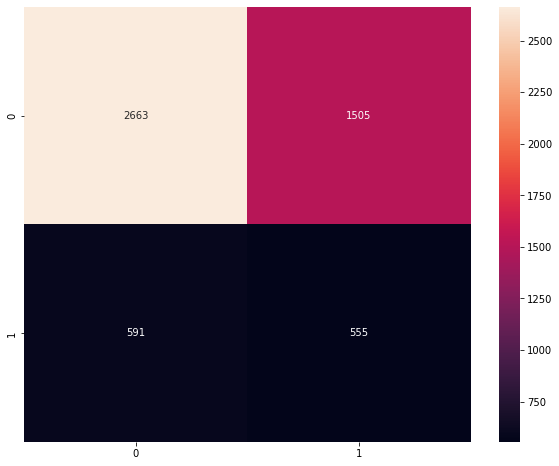

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
cf_train_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cf_train_matrix, annot=True, fmt='d')

In [41]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, preds))

0.5616043703711148


In [42]:
final_test_data['failure'] = xgb.predict(final_test_data)

#submission.to_csv('mean_benchmark.csv')

In [43]:
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')

In [44]:
submission = pd.concat([test['id'],final_test_data['failure']],axis = 1)
submission.to_csv('attemp1.csv')